## Load sample village data and perform linear regression

#### Using a simple population-area relationship based on village areas from HRSL and population estimates of villages visited

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [2]:
# read in village data with population & area
df = pd.read_csv('./trimmed_pop_data.csv')
df.set_index('VillageID',inplace=True)
print(df.shape)
df.head()

(15, 8)


,area_sqm,Region,Area,Locality,Population,HRSL_POP,HRSL_DENS,Village_dens
VillageID,,,,,,,,
8,36639.22262,Northern,SLRE,Gberi Mamanki,700,257.029066,7015.134249,19105.208840
9,28181.89664,Northern,SLRE,Kafunka,386,197.714666,7015.662157,13696.736060
2,11261.51290,Northern,Scarcies,Mahelah,200,102.582727,9109.142627,17759.603160
3,21585.31227,Northern,Scarcies,Makumpa,270,196.616894,9108.827858,12508.505630
10,36645.51011,Northern,SLRE,Mange,300,312.325107,8522.875147,8186.541792


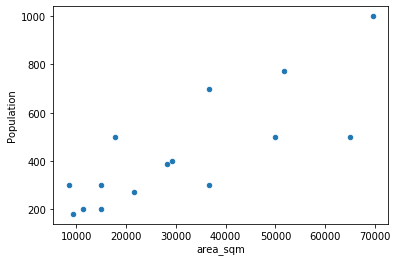

In [3]:
# examine data
%matplotlib inline
df.plot.scatter('area_sqm','Population')

count       15.000000
mean     31029.962264
std      20070.303411
min       8456.781311
25%      15041.170810
50%      28181.896640
75%      43265.176015
max      69576.731900
Name: area_sqm, dtype: float64

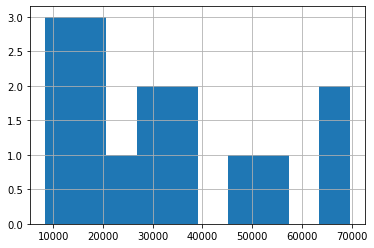

In [4]:
df.area_sqm.hist()
df.area_sqm.describe()

count      15.000000
mean      433.933333
std       235.637878
min       180.000000
25%       285.000000
50%       386.000000
75%       500.000000
max      1000.000000
Name: Population, dtype: float64

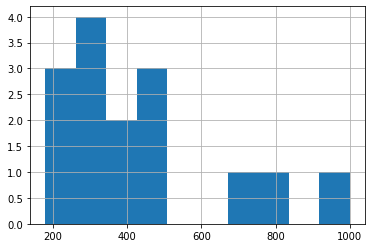

In [5]:
df.Population.hist()
df.Population.describe()

count    15.000000
mean      5.946640
std       0.514684
min       5.192957
25%       5.651102
50%       5.955837
75%       6.214608
max       6.907755
Name: logpop, dtype: float64

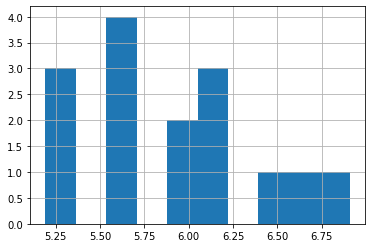

In [6]:
# use log of population to normalize 
df['logpop'] = np.log(df['Population'])
df.logpop.hist()
df.logpop.describe()

count    1.500000e+01
mean     2.516506e-16
std      1.035098e+00
min     -1.164181e+00
25%     -8.246000e-01
50%     -1.468851e-01
75%      6.310143e-01
max      1.987997e+00
Name: area_scaled, dtype: float64

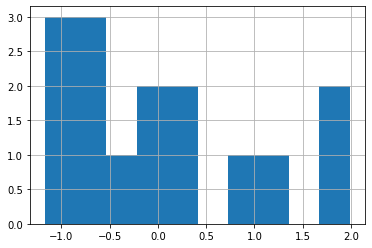

In [8]:
# standardize area
scaler = StandardScaler()
scaler.fit(df[['area_sqm']])
df['area_scaled'] = scaler.transform(df[['area_sqm']])
df.area_scaled.hist()
df.area_scaled.describe()

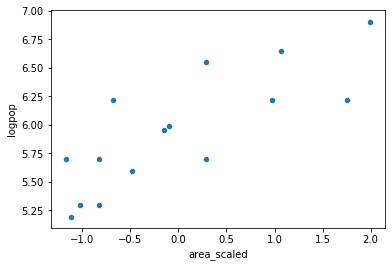

In [9]:
# see if relationship looks OK for linear
df.plot.scatter('area_scaled','logpop')

In [10]:
# linear regression of raw data
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df.area_scaled,
    df.logpop
)

In [11]:
# Model results
print('Slope: {}'.format(slope))
print('Intercept: {}'.format(intercept))
print('R: {}'.format(r_value))
print('p: {}'.format(p_value))
print('Standard Error: {}'.format(std_err))
print('R2: {}'.format(r_value**2))

Slope: 0.3997417254659599
Intercept: 5.946640122760374
R: 0.8039344504098532
p: 0.00030387742371833866
Standard Error: 0.08201592527832444
R2: 0.6463106005557928


Text(0, 0.5, 'Log of Population')

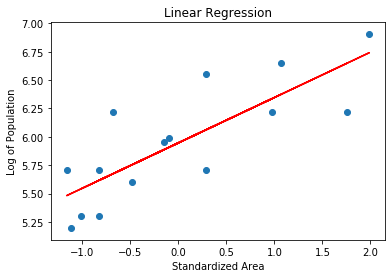

In [12]:
plt.scatter(df['area_scaled'],df['logpop'])
plt.plot(df['area_scaled'], intercept + slope * df['area_scaled'], 'r' )
plt.title('Linear Regression')
plt.xlabel('Standardized Area')
plt.ylabel('Log of Population')

Text(0.5, 0, 'Area (scaled)')

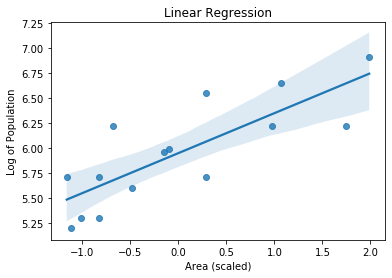

In [13]:
# plot the linear regression with standard error
# Requires seaborn
import seaborn as sns
rp = sns.regplot(
    x='area_scaled',
    y='logpop',
    data=df,
)
rp.set_title('Linear Regression')
rp.set_ylabel('Log of Population')
rp.set_xlabel('Area (scaled)')



## Predict Population for HRSL settlements

In [28]:
# load the village extents
# village_df = pd.read_csv('./hrsl_settlement_mangrove_100m.csv')
village_df = pd.read_csv('./hrsl_settlement_mangrove_100m_v2.csv')
village_df.set_index('OBJECTID',inplace=True)
print(village_df.shape)
village_df.head()

(33695, 5)


,Id,Shape_Length,Shape_Area,area_sqm,predicted_pop
OBJECTID,,,,,
-1,192319,0.001111,7.716049e-08,913.647706,205.564170
-1,192320,0.004444,7.716049e-07,9136.460945,243.539912
-1,192321,0.001111,7.716049e-08,913.647707,205.564170
-1,192360,0.001111,7.716049e-08,913.648950,205.564175
-1,192396,0.001667,1.543210e-07,1827.299144,209.472865


In [29]:
# get scaled area, re-using standard scaler for the same transform
village_df.drop(['Shape_Length','Shape_Area'],inplace=True, axis=1)
village_df['area_scaled'] = scaler.transform(village_df[['area_sqm']])
# drop any NAs
village_df.dropna(subset=['area_scaled'])
village_df.area_scaled.describe()

count    33695.000000
mean        -0.387674
std         90.153025
min         -1.553208
25%         -1.551647
50%         -1.551467
75%         -1.454278
max      15980.938844
Name: area_scaled, dtype: float64

In [31]:
# run the prediction. Warning comes from a large polygon that is
# dropped in the next step
village_df['log_predicted_pop'] = intercept + slope * village_df['area_scaled']
village_df['predicted_pop'] = np.exp(village_df['log_predicted_pop'])

In [32]:
# remove anything larger than the max area in the sample data
village_df_subset = village_df.loc[village_df.area_sqm < df.area_sqm.max()]
print(village_df_subset.shape)
village_df_subset.predicted_pop.max()

(33343, 5)


837.9045091058313

count    33343.000000
mean       216.546535
std         38.252060
min        205.564170
25%        205.692401
50%        205.707226
75%        213.813095
max        837.904509
Name: predicted_pop, dtype: float64


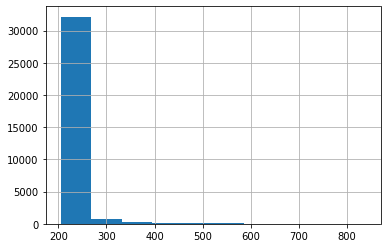

In [33]:
print(village_df_subset.predicted_pop.describe())
village_df_subset.predicted_pop.hist()

In [34]:
village_df_subset.to_csv('predicted_village_population_lm.csv')